In [56]:
import lmfit
import os
from lmfit.models import GaussianModel,LorentzianModel
import numpy as np
from matplotlib import pyplot as plt
import rampy as rp
import scipy
import spectrochempy

class raman_analyzer():
    def __init__(self,name,min,max):
        self.name = name
        self.min = min
        self.max = max
        self.spectrum = np.genfromtxt(self.name)
        self.spectrum_resample =[]
        self.spectrum_corr = []
        self.spectrum_fit = []
        self.ese0 = 0.0
        self.sigma = 0.0
        self.y_base = []
        self.peak_wavenumber = []
        self.peak_signal = []
        self.raman()
        self.peak_finder()
        self.peak_filtered = []
        self.signal_filtered = []
        self.peak_organizer()
    def raman(self):
        x_new = np.arange(self.min, self.max, 0.5)
        y_new = rp.resample(self.spectrum[:,0], self.spectrum[:,1], x_new)
        self.spectrum_resample = np.vstack((x_new,y_new)).T
        y_smo_10 = rp.smooth(self.spectrum_resample[:,0],self.spectrum_resample[:,1],method="whittaker",Lambda=3000,window_length=7)
        self.spectrum_resample = np.vstack((x_new,y_smo_10)).T
        d = scipy.signal.argrelextrema(self.spectrum_resample, np.less)
        points = len(d[0])
        bir=np.zeros((points,2))
        for i in range(len(d[0])):
            wavenumber=self.spectrum_resample[d[0][i]][0]
            bir[i][0]=wavenumber
            bir[i][1]=wavenumber+5
        y_corr, self.y_base = rp.baseline(self.spectrum_resample[:,0],self.spectrum_resample[:,1],bir,'drPLS')
        x = self.spectrum_resample[:,0]
        x_fit = x[np.where((x > self.min)&(x < self.max))]
        y_fit = y_corr[np.where((x > self.min)&(x < self.max))]
        self.spectrum_corr = np.column_stack((x_fit,y_fit))
        self.ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
        y_fit[:,0] = y_fit[:,0]/np.amax(y_fit[:,0])*10 # normalise spectra to maximum intensity, easier to handle
        self.spectrum_fit = np.column_stack((x_fit,y_fit))
        self.sigma = abs(self.ese0*y_fit[:,0])
    def peak_finder(self):
        peaks_1 = scipy.signal.find_peaks(self.spectrum_fit.T[1])
        saddles = scipy.signal.argrelmin(self.spectrum_fit.T[1])
        peaks = np.insert(peaks_1[0],0,saddles[0])
        peaks = np.sort(peaks)
        for peak in peaks:
            self.peak_wavenumber.append(self.spectrum_fit.T[0][peak])
            self.peak_signal.append(self.spectrum_fit.T[1][peak])
    def peak_organizer(self):
        for i in range(len(self.peak_wavenumber)):
            if self.peak_signal[i] > 1.8:
                self.peak_filtered.append(self.peak_wavenumber[i])
                self.signal_filtered.append(self.peak_signal[i])
def raman_plot(a,min,max):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(a.spectrum_resample[:,0],a.spectrum_resample[:,1],'ko',markersize=1,label='spectrum_resample')
    plt.plot(a.spectrum_corr[:,0],a.spectrum_corr[:,1],'ro',markersize=1,label='spectrum_corr')
    plt.plot(a.spectrum_resample[:,0],a.y_base,'g--',label='baseline',linewidth=2)
    plt.xlim(min,max)
    plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
    plt.ylabel("Normalized intensity, a. u.", fontsize = 12)
    plt.legend(fontsize=10)
    plt.subplot(1,2,2)
    plt.plot(a.spectrum_fit[:,0],a.spectrum_fit[:,1],'#F5420a',marker='.',markersize=3,label='spectrum_fit')
    plt.scatter(a.peak_wavenumber,a.peak_signal,s=100,c='#0af57c',marker='o')
    plt.ylim(-1,11)
    plt.xlim(min,max)
    plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
def residual(pars,x,data=None,eps=None):
    model=0.0
    peaks_split=[]
    for i in range(4):
        a = 'a'+ str(i+1)
        f = 'f'+ str(i+1)
        l = 'l'+ str(i+1)
        peak = 'peak'+str(i+1)
        amp = pars[a].value
        freq = pars[f].value
        hwhm = pars[l].value
        locals()[peak] = rp.lorentzian(x,amp,freq,hwhm)
        model += locals()[peak]
        peaks_split.append(locals()[peak])
    if data is None:
        return model,peaks_split# if we don't have data, the function only returns the direct calculation
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated
class peak_fitting():
    def __init__(self,peaks,amp,hwhm,method,spectrum):
        self.peaks = peaks
        self.amp = amp
        self.hwhm = hwhm
        self.method = method
        self.model = 0.0
        self.data = None
        self.eps = None
        self.spectrum = spectrum
        self.x = self.spectrum[:,0]
        self.y = self.spectrum[:,1]
        self.params = lmfit.Parameters()
        self.param_gen()
        for i in range(len(self.peaks)):
            self.params['f'+str(i+1)].vary = False
        self.result = lmfit.minimize(residual,self.params,self.method,args=(self.x,self.y))
        for i in range(len(self.peaks)):
            self.params['f'+str(i+1)].vary = True
        self.result = lmfit.minimize(residual,self.params,self.method,args=(self.x,self.y))
        self.y_out,self.peaks_split = residual(self.result.params,self.spectrum[:,0])
    def param_gen(self):
        for i in range(len(self.peaks)):
            self.params.add_many(('a'+str(i+1),self.amp[i], True , self.amp[i]-1 , self.amp[i]+1, None),\
                            ('f'+str(i+1),self.peaks[i],True,self.peaks[i]-10,self.peaks[i]+30,None),\
                            ('l'+str(i+1),self.hwhm[i] , True , self.hwhm[i]-10 , self.hwhm[i]+30, None))

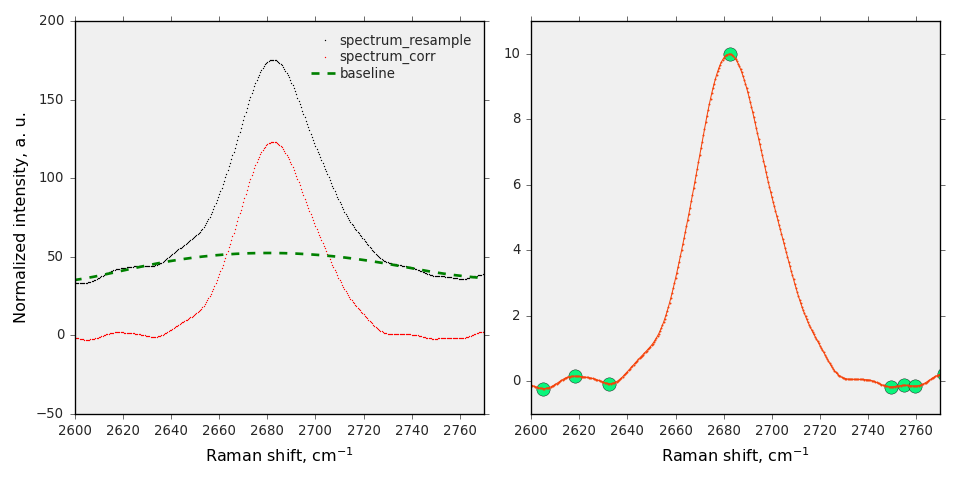

In [61]:
raman = raman_analyzer('./3rd_1/2209303rdonpur.1.dat',1200,3000)
raman_plot(raman,2600,2770)
x_new = np.arange(2640,2750, 0.5)
y_new = rp.resample(raman.spectrum_fit[:,0], raman.spectrum_fit[:,1], x_new)
spectrum = np.vstack((x_new,y_new)).T

In [34]:
peaks = [2650,2670,2690,2710]
amp  = [3,2,2,3]
hwhm = [10,20,20,10]
method = 'powell'
peak_fitting_1 = peak_fitting(peaks,amp,hwhm,method,spectrum)

Text(0, 0.5, 'Normalized intensity, a. u.')

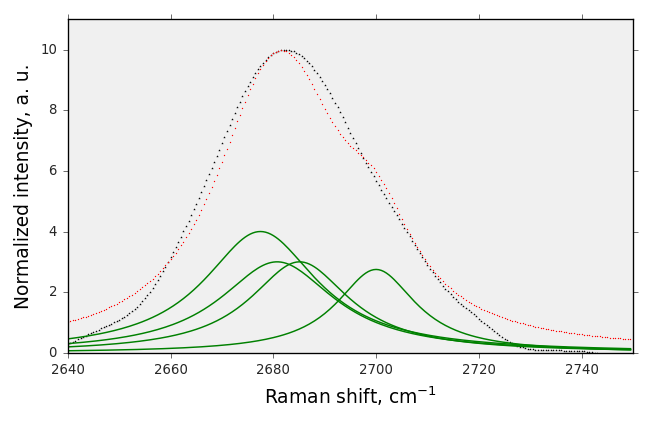

In [35]:
plt.figure()
plt.plot(spectrum[:,0],spectrum[:,1],'k*',markersize=2)
plt.plot(spectrum[:,0],peak_fitting_1.y_out,'ro',markersize=1)
for i in range(len(peaks)):
    plt.plot(spectrum[:,0],peak_fitting_1.peaks_split[i],'g-',linewidth=1.1)
plt.xlim(2640,2750)
plt.ylim(0,11)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)

In [ ]:
plt.figure()
plt.plot(spectrum_fit[:,0],spectrum_fit[:,1],'k*',markersize=2)
plt.plot(spectrum_fit[:,0],yout,'ro',markersize=1)
for i in range(len(peaks)):
    plt.plot(spectrum_fit[:,0],peaks[i],'g-',linewidth=1.1)
plt.xlim(870,1300)
plt.ylim(0,11)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)

In [304]:
peak_fitting_1.result

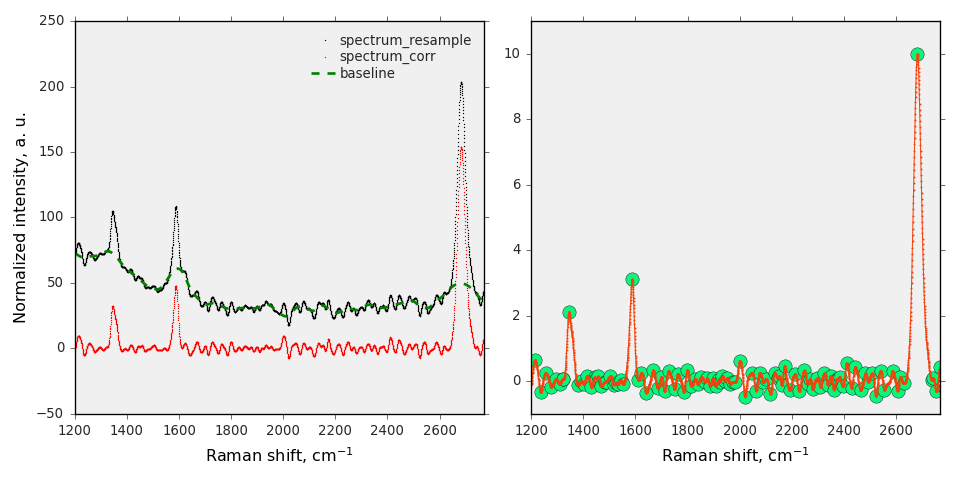

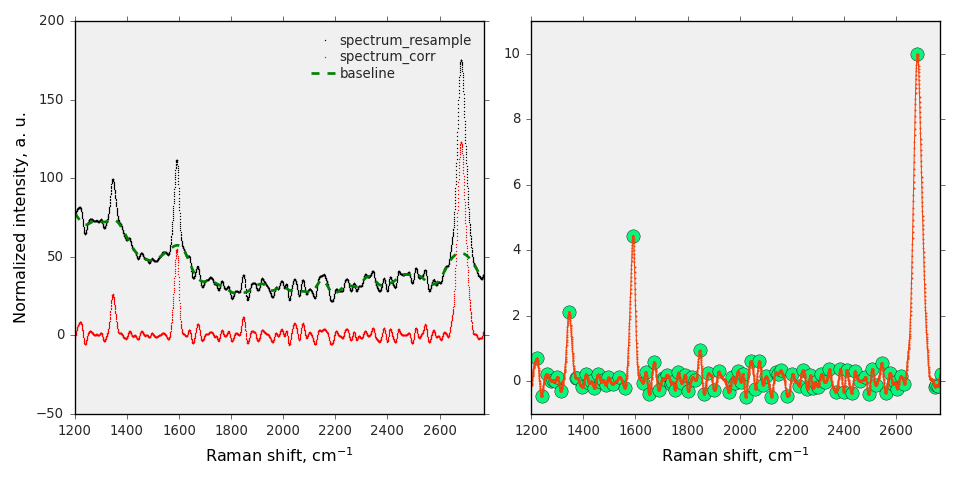

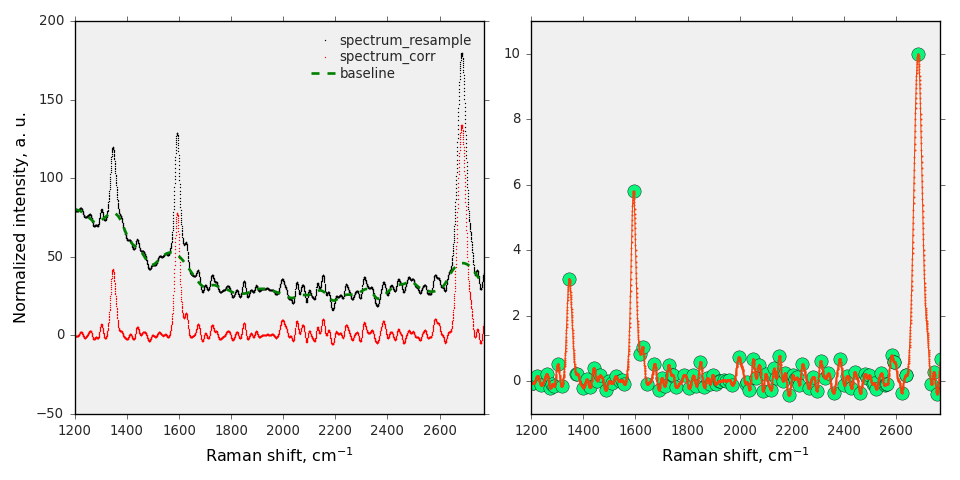

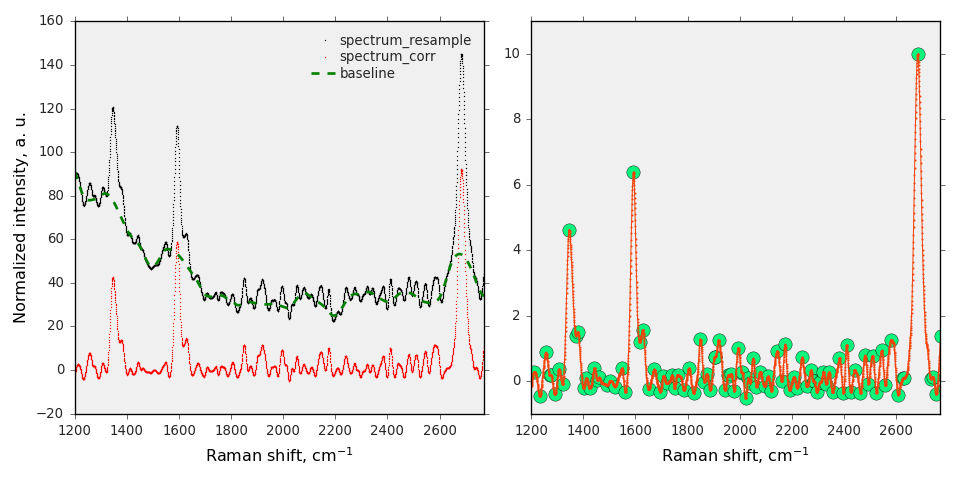

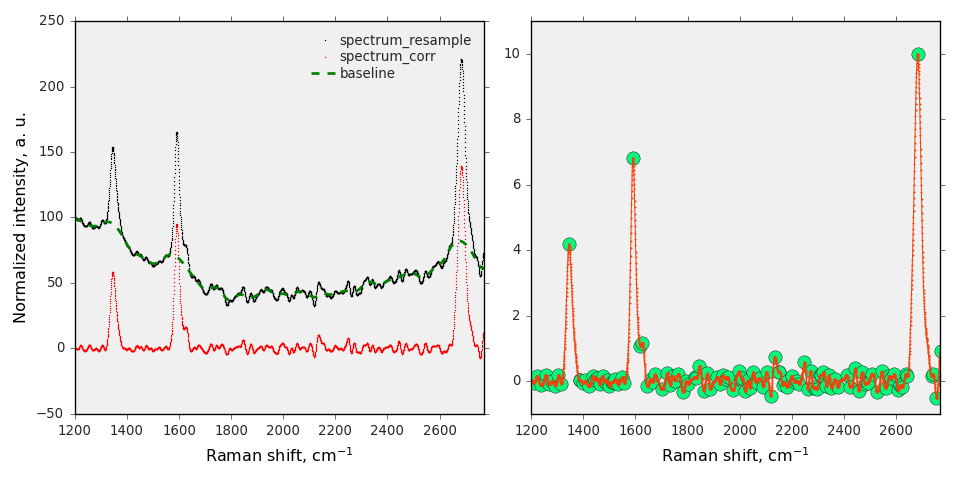

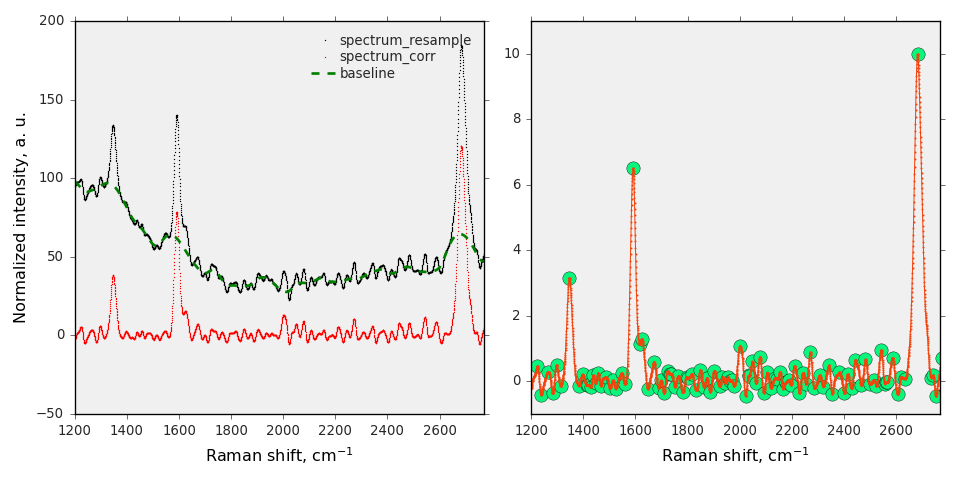

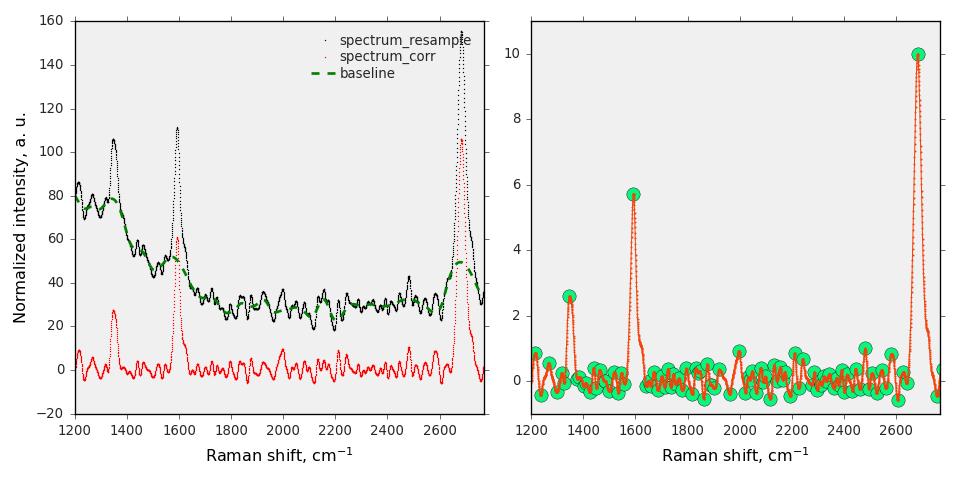

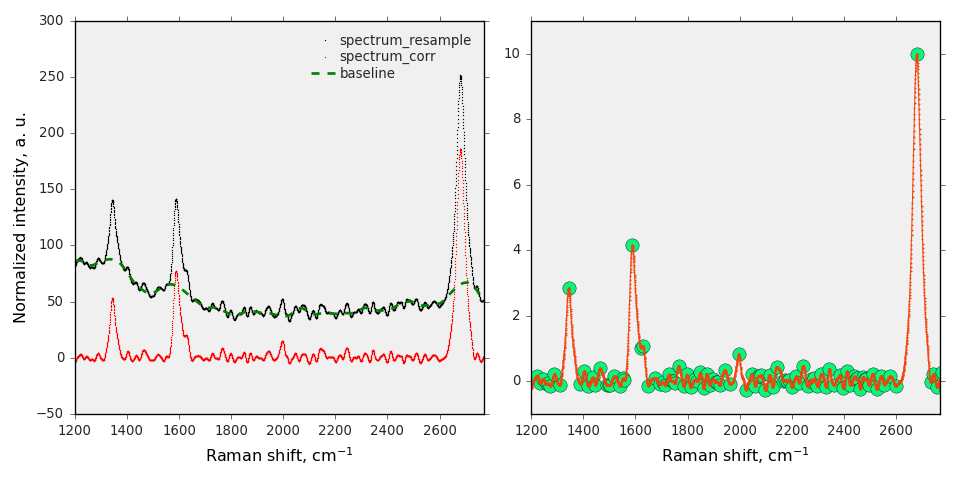

In [36]:
g = os.walk(r'./3rd_1')
peaks = []
signals = []
for path,dir_list,file_list in g:
    for file_name in file_list:
        a = os.path.join(path,file_name)
        raman = raman_analyzer(a,1200,3000)
        peaks.append(raman.peak_wavenumber)
        signals.append(raman.peak_signal)
        raman_plot(raman,1200,2770)


In [51]:
signals_new = []
peaks_new = []
for i in range(len(peaks)):
    signal_new = []
    peak_new = []
    for j in range(len(peaks[i])):
        if signals[i][j] > 1.8:
            signal_new.append(signals[i][j])
            peak_new.append(peaks[i][j])
    signals_new.append(signal_new)
    peaks_new.append(peak_new)